<a href="https://colab.research.google.com/github/melirandazzo/trabajo_ciencia_datos/blob/main/NPL_Randazzo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NPL Carta natal personal

El objetivo de este trabajo es detectar aspectos claves de la carta natal para un analisis de la personalidad segín la astrología.

## Instalar librerias

In [1]:
!pip install python-docx==0.8.11
!pip install nltk
!pip install spacy
!pip install textblob
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for python-docx: filename=python_docx-0.8.11-py3-none-any.whl size=184488 sha256=b68c471a787980b2fa326f7d336cb6d2ef87b2a53ebb2494cf3f058e5338cc17
  Stored in directory: /root/.cache/pip/wheels/80/27/06/837436d4c3bd989b957a91679966f207bfd71d358d63a8194d
Successfully built python-docx


In [84]:
import requests
from docx import Document
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from spacy import displacy
import networkx as nx
import plotly.express as px
import plotly.io as pio
import pandas as pd

In [3]:
nltk.download('punkt_tab')
nltk.download('stopwords')
!python -m spacy download en_core_web_sm
nltk.download('averaged_perceptron_tagger_eng')
nltk_stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


### Carga de documento

In [4]:
# Descargar el documento
def download_file(url, local_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Cargar el archivo .docx
def extract_text_from_docx(file_path):
    document = Document(file_path)
    full_text = []
    for para in document.paragraphs:
        full_text.append(para.text)
    return '\n'.join(full_text)

url = 'https://github.com/melirandazzo/trabajo_ciencia_datos/raw/main/Carta_natal.docx'
local_file_path = 'Carta_natal.docx'
download_file(url, local_file_path)

# Ruta del archivo .docx (local path)
file_path = local_file_path

# Extraer el texto
extracted_text = extract_text_from_docx(file_path)


### Limpieza y tokenización

In [18]:
def preprocess_text(text):
    # Convertir el texto a minúsculas
    text = text.lower()
    # Remover caracteres no alfabéticos
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text)
    # Tokenizar el texto
    tokens = word_tokenize(text)
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens


# Preprocesar el texto y mostrar los tokens
preprocessed_tokens = preprocess_text(extracted_text)
print("\nTokens preprocesados:")
print(preprocessed_tokens)



Tokens preprocesados:
['st', 'house', 'ascendant', 'asc', 'physical', 'personality', 'ascendant', 'asc', 'symbolizes', 'basic', 'personality', 'traits', 'physical', 'appearance', 'temperament', 'behaviour', 'relationship', 'life', 'first', 'impression', 'person', 'gives', 'ascendant', 'capricorn', 'capricorn', 'ruler', 'saturn', 'people', 'capricorn', 'ascendant', 'must', 'first', 'become', 'aware', 'two', 'opposing', 'sides', 'one', 'obedience', 'performing', 'duties', 'properly', 'need', 'manage', 'energy', 'well', 'requires', 'discipline', 'selfcontrol', 'must', 'achieve', 'social', 'prestige', 'recognition', 'side', 'ability', 'organize', 'practical', 'matters', 'achieve', 'goals', 'also', 'ability', 'enjoy', 'sensual', 'pleasures', 'ruler', 'ascendant', 'saturn', 'people', 'tend', 'act', 'slowly', 'caution', 'avoid', 'kind', 'control', 'love', 'solitude', 'hate', 'crowds', 'want', 'stand', 'isolate', 'others', 'actions', 'valued', 'time', 'may', 'become', 'politicians', 'consulta

In [5]:
# Procesar con spaCy
nlp = spacy.load("en_core_web_sm")
extracted_text_nlp = nlp(extracted_text)

In [6]:
# Tokenización y lematización
tokens = [token.lemma_ for token in extracted_text_nlp if not token.is_stop and not token.is_punct]
print(tokens)


['1st', 'house', 'Ascendant', 'ASC', '\n', 'physical', 'personality', '\n', 'Ascendant', 'ASC', 'symbolizes', 'basic', 'personality', 'trait', 'physical', 'appearance', 'temperament', 'behaviour', 'relationship', 'life', 'impression', 'person', 'give', '\n\n', 'Ascendant', 'Capricorn', 'Capricorn', 'ruler', 'Saturn', '\n', 'People', 'Capricorn', 'Ascendant', 'aware', 'oppose', 'side', 'obedience', 'perform', 'duty', 'properly', 'need', 'manage', 'energy', 'require', 'discipline', 'self', 'control', 'achieve', 'social', 'prestige', 'recognition', 'ability', 'organize', 'practical', 'matter', 'achieve', 'goal', 'ability', 'enjoy', 'sensual', 'pleasure', '\n\n', 'ruler', 'Ascendant', 'Saturn', '\n', 'people', 'tend', 'act', 'slowly', 'caution', 'avoid', 'kind', 'control', 'love', 'solitude', 'hate', 'crowd', 'want', 'stand', 'isolate', 'action', 'value', 'time', 'politician', 'consultant', 'engineer', 'etc', 'main', 'feature', 'endurance', '\n\n', 'ruler', 'Ascendant', 'Saturn', 'Capricor

In [7]:
#Establecer aspectos y palabras clave de astrologia
# Lista de signos zodiacales y sus elementos
zodiac_signs = {
    'aries': 'fire', 'taurus': 'earth', 'gemini': 'air', 'cancer': 'water',
    'leo': 'fire', 'virgo': 'earth', 'libra': 'air', 'scorpio': 'water',
    'sagittarius': 'fire', 'capricorn': 'earth', 'aquarius': 'air', 'pisces': 'water'
}

# Añadir detección con regex para casas astrales
def detect_houses(text):
    house_pattern = re.compile(r"\b([1-9]|1[0-2])(st|nd|rd|th) house\b")
    matches = house_pattern.findall(text)
    return [f"{m[0]}{m[1]} house" for m in matches]

# Lista personalizada de palabras clave
planets = ["Sun", "Moon", "Mercury", "Venus", "Mars", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
signs = ["Aries", "Taurus", "Gemini", "Cancer", "Leo", "Virgo", "Libra", "Scorpio", "Sagittarius", "Capricorn", "Aquarius", "Pisces"]
astrological_aspects = ["Sun", "Moon", "Ascendant", "Lilith", "Chiron", "North Node", "South Node"]
houses = detect_houses(extracted_text)


In [69]:
# Detectar palabras clave
keywords = [token.text for token in extracted_text_nlp if token.text in planets + houses + signs + astrological_aspects]
# Eliminar duplicados
unique_keywords = list(set(keywords))
print("Palabras clave encontradas:", unique_keywords)

Palabras clave encontradas: ['Mercury', 'Scorpio', 'Virgo', 'Gemini', 'Uranus', 'Lilith', 'Pluto', 'Saturn', 'Mars', 'Chiron', 'Sagittarius', 'Jupiter', 'Neptune', 'Ascendant', 'Libra', 'Sun', 'Capricorn', 'Aries', 'Moon', 'Pisces', 'Venus', 'Taurus']


In [12]:
# Estadísticas básicas
num_sentences = len(list(extracted_text_nlp.sents))
num_words = len(tokens)
print(f"Número de oraciones: {num_sentences}, Número de palabras: {num_words}")

# Frecuencia de palabras clave
freq = Counter(keywords)
print("Frecuencia de palabras clave:", freq)


Número de oraciones: 398, Número de palabras: 3672
Frecuencia de palabras clave: Counter({'Venus': 34, 'Sun': 33, 'Saturn': 29, 'Moon': 28, 'Mercury': 24, 'Uranus': 24, 'Neptune': 22, 'Mars': 19, 'Pluto': 16, 'Jupiter': 15, 'Ascendant': 14, 'Capricorn': 11, 'Gemini': 9, 'Chiron': 8, 'Lilith': 6, 'Taurus': 5, 'Pisces': 5, 'Libra': 3, 'Sagittarius': 3, 'Scorpio': 3, 'Aries': 2, 'Virgo': 2})


In [83]:
pio.templates.default = "plotly_dark"

# Convertir a DataFrame de pandas para usar con plotly
df_freq = pd.DataFrame(list(freq.items()), columns=["Palabra clave", "Frecuencia"])

# Crear el gráfico de barras con Plotly
fig = px.bar(df_freq, x="Palabra clave", y="Frecuencia",
             title="Frecuencia de palabras clave en la carta natal",
             labels={"Palabra clave": "Palabras clave", "Frecuencia": "Frecuencia"},
             color="Frecuencia", color_continuous_scale="Magma")

# Rotar las etiquetas del eje x
fig.update_layout(xaxis_tickangle=-45)

# Mostrar el gráfico
fig.show()


In [24]:
# Renderizar árbol sintáctico
displacy.render(extracted_text_nlp, style="dep", jupyter=True)

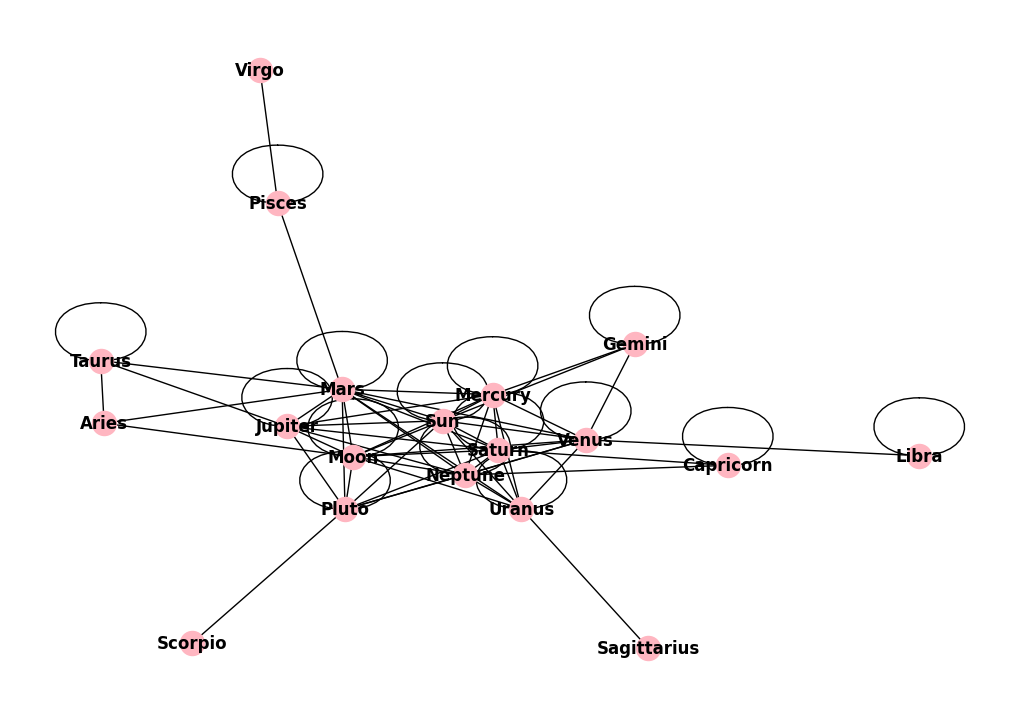

In [85]:
#Grafo para mostrar cómo se relacionan planetas, casas y signos.
G = nx.Graph()
for sent in extracted_text_nlp.sents:
    entities = [token.text for token in sent if token.text in planets + houses + signs]
    for i in range(len(entities)):
        for j in range(i + 1, len(entities)):
            G.add_edge(entities[i], entities[j])

# Dibujar el grafo
plt.figure(figsize=(10, 7))
nx.draw(G, with_labels=True, node_color="lightpink", font_weight="bold")
plt.show()


In [27]:
# Clasificar oraciones por temas
themes = {}
for sent in extracted_text_nlp.sents:
    planets_in_sent = [token.text for token in sent if token.text in planets]
    houses_in_sent = [token.text for token in sent if token.text in houses]
    signs_in_sent = [token.text for token in sent if token.text in signs]
    aspects_in_sent = [token.text for token in sent if token.text in astrological_aspects]

    if planets_in_sent:
        themes[sent.text] = {
            "planets": planets_in_sent,
            "houses": houses_in_sent,
            "signs": signs_in_sent,
            "aspects": aspects_in_sent
        }

# Mostrar resultados
for sentence, details in themes.items():
    print(f"Oración: {sentence}")
    print(f"Detalles: {details}")


Oración: Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': ['Capricorn', 'Capricorn', 'Capricorn'], 'aspects': ['Ascendant', 'Ascendant']}
Oración: more -»

The ruler of the Ascendant - Saturn

Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': [], 'aspects': ['Ascendant']}
Oración: The ruler of the Ascendant (Saturn) in Capricorn
These people raise slowly but steadily without others noticing.
Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': ['Capricorn'], 'aspects': ['Ascendant']}
Oración: The ruler of the Ascendant (Saturn) in the 12th House

Detalles: {'planets': ['Saturn'], 'houses': [], 'signs': [], 'aspects': ['Ascendant']}
Oración: Ascendant aspects
Square Moon (3°22’, Separating)
Trine Jupiter (6°26’, Separating)
Contra-Parallel Mercury (0°12’)

10th house - Medium Coeli (MC)
Career, prestige and reputation
Medium Coeli (MC

In [26]:
# Buscar verbos y sus relaciones
for token in extracted_text_nlp:
    if token.pos_ == "VERB":
        related_keywords = [child.text for child in token.children if child.text in planets + signs + houses + astrological_aspects]
        if related_keywords:
            print(f"Verbo: {token.text}, Relacionado con: {related_keywords}")

Verbo: expands, Relacionado con: ['Jupiter']
Verbo: manifest, Relacionado con: ['Mars']
Verbo: behave, Relacionado con: ['Aries']
Verbo: symbolizes, Relacionado con: ['Sun']
Verbo: creates, Relacionado con: ['Sun', 'Sun']
Verbo: gives, Relacionado con: ['Sun']
Verbo: tells, Relacionado con: ['Moon']
Verbo: means, Relacionado con: ['Moon', 'Moon']
Verbo: indicates, Relacionado con: ['Moon']
Verbo: aspects, Relacionado con: ['Moon', 'Sun']
Verbo: learning, Relacionado con: ['Mercury']
Verbo: have, Relacionado con: ['Mercury']
Verbo: feels, Relacionado con: ['Mercury']
Verbo: represents, Relacionado con: ['Mercury']
Verbo: indicates, Relacionado con: ['Mercury']
Verbo: symbolizes, Relacionado con: ['Moon']
Verbo: tells, Relacionado con: ['Venus']
Verbo: causes, Relacionado con: ['Venus']
Verbo: symbolizes, Relacionado con: ['Uranus']
Verbo: tells, Relacionado con: ['Mars']
Verbo: gives, Relacionado con: ['Mars']
Verbo: suggests, Relacionado con: ['Mars']
Verbo: aspects, Relacionado con: [

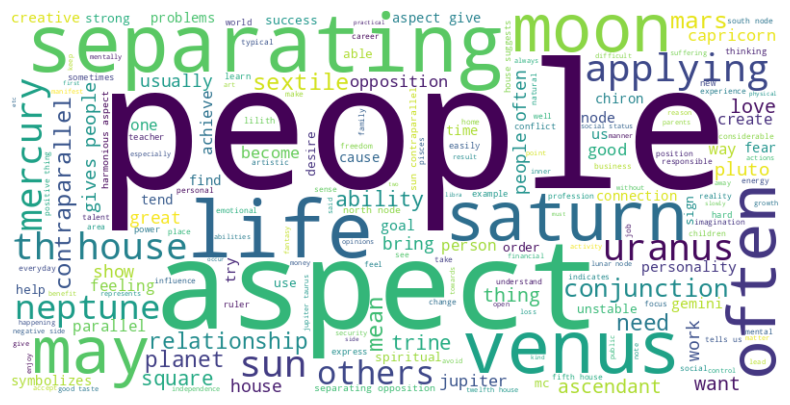

In [86]:
def plot_wordcloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Visualizar las palabras con una nube de palabras
plot_wordcloud(preprocessed_tokens, '')

# Evaluar caracteristicas personales


Frecuencia de signos zodiacales:
Counter({'capricorn': 11, 'gemini': 9, 'taurus': 5, 'pisces': 5, 'libra': 3, 'sagittarius': 3, 'scorpio': 3, 'aries': 2, 'virgo': 2})


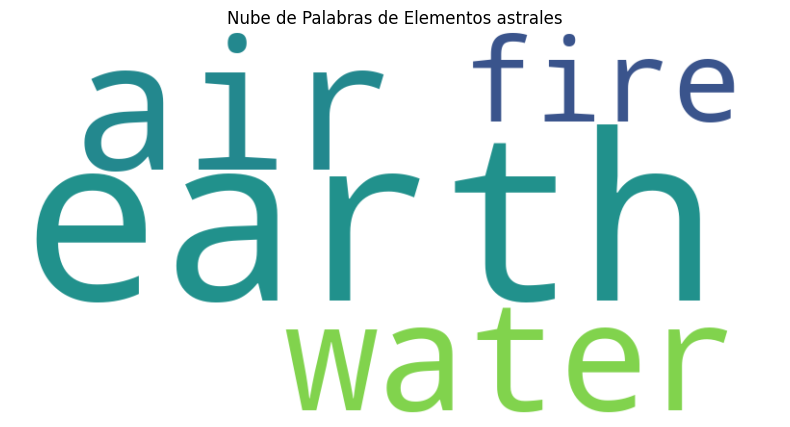

In [41]:
# Filtrar y contar palabras clave
def filter_and_count_keyword(tokens, keywordList):
    filtered = [word for word in tokens if word in keywordList]
    counts = Counter(filtered)
    return counts

def plot_element_wordcloud(sign_counts):
    # Convertir los signos a sus elementos correspondientes
    element_counts = Counter()
    for sign, count in sign_counts.items():
        element = zodiac_signs[sign]
        element_counts[element] += count

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(element_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de Palabras de Elementos astrales')
    plt.show()

# Filtrar y contar signos zodiacales
zodiac_sign_lower = [zodiac_sign.lower() for zodiac_sign in zodiac_signs]
zodiac_sign_counts = filter_and_count_keyword(preprocessed_tokens, zodiac_sign_lower)
print("\nFrecuencia de signos zodiacales:")
print(zodiac_sign_counts)

plot_element_wordcloud(zodiac_sign_counts)

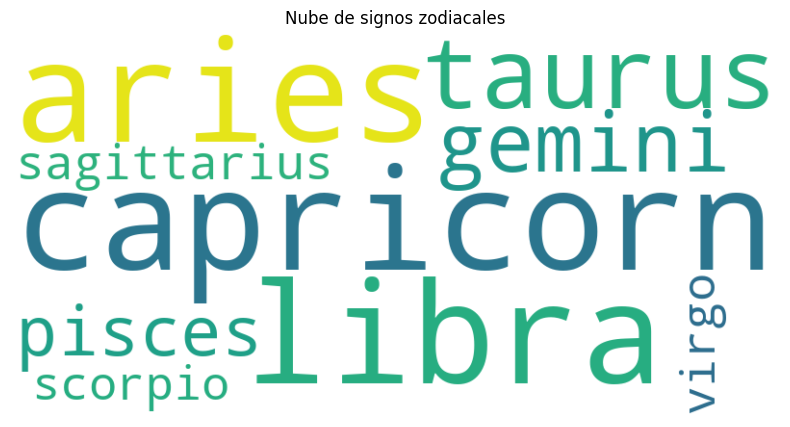

In [42]:
signs_lower = [sign.lower() for sign in signs]
plot_wordcloud(filter_and_count_keyword(preprocessed_tokens, signs_lower), "Nube de signos zodiacales")

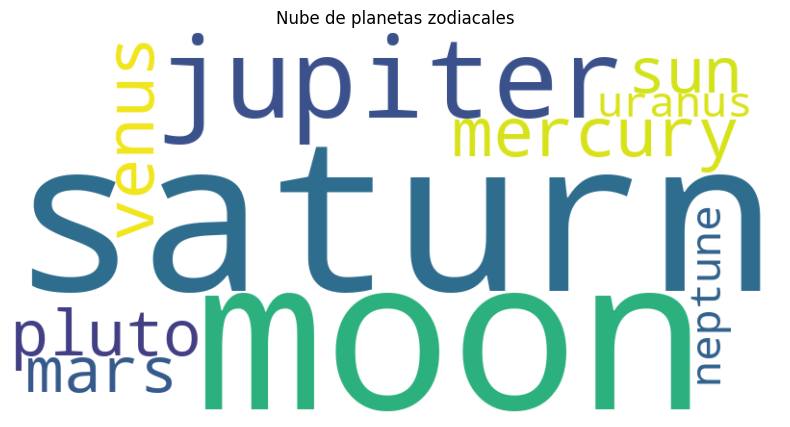

In [38]:
planets_lower = [planet.lower() for planet in planets]
plot_wordcloud(filter_and_count_keyword(preprocessed_tokens, planets_lower), "Nube de planetas zodiacales")

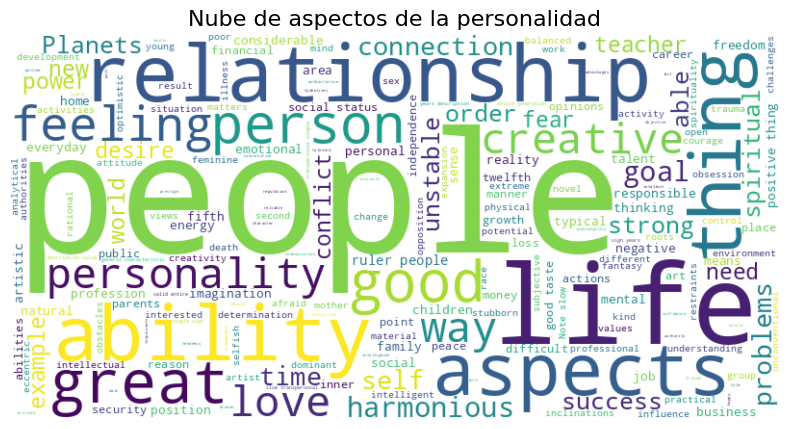

In [68]:
# Función para generar palabras clave
def generate_filtered_words(text, exclusion_lists):
    # Procesar el texto con spaCy
    doc = text

    # Combinar todas las listas de palabras clave en un solo conjunto para exclusión
    exclusion_set = set(word.lower() for lst in exclusion_lists for word in lst)

    # Expresión regular para números ordinales (e.g., "4th", "12th")
    ordinal_pattern = re.compile(r"\b[0-9]+(st|nd|rd|th)\b", re.IGNORECASE)

    # Extraer adjetivos y sustantivos, asegurando que no estén en las listas de exclusión
    filtered_words = [
        token.text
        for token in doc
        if token.pos_ in ["ADJ", "NOUN"]
        and not token.is_stop
        and token.text.lower() not in exclusion_set
        and not ordinal_pattern.match(token.text)    # No es un número ordinal
    ]

    return filtered_words


# Detectar casas astrales
houses = detect_houses(extracted_text)

# Listas personalizadas de palabras a excluir
other = ["House", "Aspect", "Conjunction", "Astrology", "Planet"]

# Generar lista filtrada
filtered_words = generate_filtered_words(
    extracted_text_nlp,
    exclusion_lists=[planets, signs, astrological_aspects, houses, other]
)

# Generar la nube de palabras
plot_wordcloud(filtered_words, "Nube de aspectos de la personalidad")


In [59]:
# Función para encontrar relaciones dentro de una oración
def find_related_keywords(doc, keywords):
    related = []
    for sent in doc.sents:  # Iterar sobre oraciones
        found = [ent.text for ent in sent.ents if ent.text in keywords]
        if len(found) > 1:  # Si hay más de una palabra clave en la oración
            related.append((sent.text))
    return related

# Palabras clave a buscar
keywords = planets + houses + signs + astrological_aspects

# Detectar relaciones
relationships = find_related_keywords(extracted_text_nlp, keywords)

for relationship in relationships:
  print(relationship)

Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
The ruler of the Ascendant (Saturn) in Capricorn
These people raise slowly but steadily without others noticing.
The ruler of the Ascendant (Saturn) in the 12th House

Mars fights, Saturn limits, Jupiter expands..

Sign in which the planet is located determines how the planet is manifesting itself, for example Mars may manifest itself in a way Aries would behave (vigorously and irritably) or in the manner of Taurus (more slowly, gradually and consistently)

The position of the Sun may tell us which profession would best suit the character of a person.

Sun in Gemini
People born under the sign of Gemini are people of many talents and they are able to use their skills in both theory and practice.
more -»

Sun in the 5th House
The Sun in the fifth house creates very creative people with a very strong desire for self-expression.
Sun aspects
Sextile Moon (5

## Lematización

In [ ]:
# Cargar el modelo de spaCy
nlp = spacy.load("en_core_web_sm")

doc = nlp(extracted_text)
lemmatized_text = [(token.text, token.lemma_) for token in doc]
print("Lematización:")
for word, lemma in lemmatized_text:
    print(f"{word} -> {lemma}")

Streaming output truncated to the last 5000 lines.
° -> °
22 -> 22
’ -> '
, -> ,
Applying -> apply
) -> )

 -> 

Opposition -> Opposition
Mercury -> Mercury
( -> (
5 -> 5
° -> °
54 -> 54
’ -> '
, -> ,
Separating -> Separating
) -> )

 -> 

Opposition -> Opposition
Venus -> Venus
( -> (
5 -> 5
° -> °
56 -> 56
’ -> '
, -> ,
Separating -> Separating
) -> )

 -> 

Conjunction -> Conjunction
Uranus -> Uranus
( -> (
0 -> 0
° -> °
32 -> 32
’ -> '
, -> ,
Applying -> apply
) -> )

 -> 

Contra -> Contra
- -> -
Parallel -> Parallel
Sun -> Sun
( -> (
0 -> 0
° -> °
43 -> 43
’ -> '
) -> )

 -> 

Contra -> Contra
- -> -
Parallel -> Parallel
Venus -> Venus
( -> (
0 -> 0
° -> °
53 -> 53
’ -> '
) -> )

 -> 

Parallel -> Parallel
Neptune -> Neptune
( -> (
0 -> 0
° -> °
10 -> 10
’ -> '
) -> )


  -> 

 
Uranus -> Uranus
- -> -
Originality -> Originality
, -> ,
freedom -> freedom
, -> ,
revolution -> revolution

 -> 

Uranus -> Uranus
is -> be
the -> the
power -> power
of -> of
awakening -> awakening
, ->

## Stemming

In [ ]:
ps = PorterStemmer()
stemmed_text = [ps.stem(word) for word in preprocessed_tokens]
print("\nStemming:")
print(stemmed_text)


Stemming:
['st', 'hous', 'ascend', 'asc', 'physic', 'person', 'ascend', 'asc', 'symbol', 'basic', 'person', 'trait', 'physic', 'appear', 'tempera', 'behaviour', 'relationship', 'life', 'first', 'impress', 'person', 'give', 'ascend', 'capricorn', 'capricorn', 'ruler', 'saturn', 'peopl', 'capricorn', 'ascend', 'must', 'first', 'becom', 'awar', 'two', 'oppos', 'side', 'one', 'obedi', 'perform', 'duti', 'properli', 'need', 'manag', 'energi', 'well', 'requir', 'disciplin', 'selfcontrol', 'must', 'achiev', 'social', 'prestig', 'recognit', 'side', 'abil', 'organ', 'practic', 'matter', 'achiev', 'goal', 'also', 'abil', 'enjoy', 'sensual', 'pleasur', 'ruler', 'ascend', 'saturn', 'peopl', 'tend', 'act', 'slowli', 'caution', 'avoid', 'kind', 'control', 'love', 'solitud', 'hate', 'crowd', 'want', 'stand', 'isol', 'other', 'action', 'valu', 'time', 'may', 'becom', 'politician', 'consult', 'engin', 'etc', 'main', 'featur', 'endur', 'ruler', 'ascend', 'saturn', 'capricorn', 'peopl', 'rais', 'slowli'

## POS Tagging

In [ ]:
from nltk import pos_tag

pos_tags = pos_tag(preprocessed_tokens)
print("\nPOS Tagging:")
for word, tag in pos_tags:
    print(f"{word} -> {tag}")


POS Tagging:
st -> NN
house -> NN
ascendant -> JJ
asc -> JJ
physical -> JJ
personality -> NN
ascendant -> NN
asc -> NN
symbolizes -> VBZ
basic -> JJ
personality -> NN
traits -> NNS
physical -> JJ
appearance -> NN
temperament -> NN
behaviour -> NN
relationship -> NN
life -> NN
first -> JJ
impression -> NN
person -> NN
gives -> VBZ
ascendant -> JJ
capricorn -> JJ
capricorn -> VBN
ruler -> NN
saturn -> NN
people -> NNS
capricorn -> VBP
ascendant -> JJ
must -> MD
first -> RB
become -> VB
aware -> JJ
two -> CD
opposing -> VBG
sides -> NNS
one -> CD
obedience -> NN
performing -> VBG
duties -> NNS
properly -> RB
need -> VBP
manage -> NN
energy -> NN
well -> RB
requires -> VBZ
discipline -> JJ
selfcontrol -> NN
must -> MD
achieve -> VB
social -> JJ
prestige -> NN
recognition -> NN
side -> NN
ability -> NN
organize -> VB
practical -> JJ
matters -> NNS
achieve -> VBP
goals -> NNS
also -> RB
ability -> NN
enjoy -> VBP
sensual -> JJ
pleasures -> NNS
ruler -> VBP
ascendant -> JJ
saturn -> NN
peopl

## Análisis de sentimiento

In [ ]:
# Crear un objeto TextBlob para el análisis
blob = TextBlob(extracted_text)

sentimiento = blob.sentiment

print(f"Polaridad: {sentimiento.polarity}")
print(f"Sujeción: {sentimiento.subjectivity}")

Polaridad: 0.13688797464068223
Sujeción: 0.5303579698480421


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

extracted_text_list = sent_tokenize(extracted_text)

sid = SentimentIntensityAnalyzer()
for sentence in extracted_text_list:
  print(sentence)
  ss = sid.polarity_scores(sentence)
  for k in sorted(ss):
    print('{0}: {1}, '.format(k, ss[k]), end='')

1st house - Ascendant (ASC)
Physical personality
Ascendant (ASC) - Symbolizes basic personality traits such as physical appearance, temperament, behaviour, relationship to life and the first impression the person gives.
compound: 0.2263, neg: 0.0, neu: 0.934, pos: 0.066, Ascendant in Capricorn (Capricorn ruler is Saturn)
People with Capricorn Ascendant must first become aware of their two opposing sides.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, One is obedience and performing their duties properly.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, They need to manage energy well and this requires discipline and self-control.
compound: 0.4939, neg: 0.0, neu: 0.704, pos: 0.296, They must achieve some social prestige and recognition.
compound: 0.0, neg: 0.0, neu: 1.0, pos: 0.0, The other side is the ability to organize practical matters and achieve their goals, and also the ability to enjoy sensual pleasures.
compound: 0.8689, neg: 0.0, neu: 0.59, pos: 0.41, ... more -»

The ruler of the A

## TF-IDF

In [ ]:
# Crear el vectorizador TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')  # Esto elimina palabras comunes (como "the", "and", etc.)

# Ajustar el modelo y transformar el texto
tfidf_matrix = vectorizer.fit_transform([extracted_text])

# Obtener los nombres de las características (palabras)
palabras = vectorizer.get_feature_names_out()

# Convertir la matriz TF-IDF en un formato más legible
tfidf_scores = tfidf_matrix.toarray()

# Mostrar los resultados (palabras y sus respectivos TF-IDF scores)
for palabra, score in zip(palabras, tfidf_scores[0]):
    print(f"{palabra}: {score:.4f}")

01: 0.0141
03: 0.0141
10: 0.0283
10th: 0.0283
12: 0.0141
12th: 0.0283
14: 0.0141
16: 0.0141
18: 0.0188
1st: 0.0094
21: 0.0141
22: 0.0283
23: 0.0141
25: 0.0141
26: 0.0283
27: 0.0141
28: 0.0141
2nd: 0.0047
305: 0.0047
31: 0.0141
32: 0.0141
33: 0.0141
38: 0.0141
3rd: 0.0047
40: 0.0141
41: 0.0141
43: 0.0141
45: 0.0141
47: 0.0141
49: 0.0141
4th: 0.0141
50: 0.0141
53: 0.0283
54: 0.0283
55: 0.0141
56: 0.0141
5th: 0.0188
6th: 0.0094
7th: 0.0047
8th: 0.0047
9th: 0.0047
abilities: 0.0188
ability: 0.0753
able: 0.0330
accept: 0.0188
accepted: 0.0047
accepting: 0.0047
accordance: 0.0047
according: 0.0047
achieve: 0.0471
acknowledged: 0.0047
acquaintances: 0.0047
act: 0.0047
actions: 0.0188
active: 0.0047
activities: 0.0141
activity: 0.0188
actors: 0.0094
adam: 0.0094
adapt: 0.0047
administrators: 0.0047
advantages: 0.0094
adventurous: 0.0094
affairs: 0.0094
affected: 0.0047
affection: 0.0094
affectionate: 0.0047
affects: 0.0094
afraid: 0.0141
ahead: 0.0047
aim: 0.0047
air: 0.0094
alcohol: 0.0094
al

### Resumen

In [ ]:
import re
import numpy as np
import pandas as pd
from collections import Counter
from nltk.cluster.util import cosine_distance
import networkx as nx

def pre_processing(text):
  sentences = {}
  default_st = nltk.sent_tokenize
  sents = default_st(text=text)

  pattern = r'[^a-zA-z0-9\s]'
  default_wt = nltk.word_tokenize

  for x in sents:

    t= re.sub(pattern, '', x)
    words = default_wt(t)

    new_words = [w.lower() for w in words if not w in nltk_stopwords]
    sentences[x] = new_words

  return sentences

In [ ]:
def sentence_similarity(sent1, sent2):

    all_words = list(set(sent1 + sent2))

    sent1_vals = Counter(sent1)
    sent2_vals = Counter(sent2)

    # convert to word-vectors
    sent1_vect = [sent1_vals.get(word, 0) for word in all_words]
    sent2_vect = [sent2_vals.get(word, 0) for word in all_words]

    return 1 - cosine_distance(sent1_vect, sent2_vect)

def build_similarity_matrix(sentences):
    zero_data = np.zeros(shape=(len(sentences),len(sentences)))
    similarity_matrix = pd.DataFrame(zero_data, columns=sentences.keys(),index=sentences.keys())

    for k1, v1 in sentences.items():
      for k2, v2 in sentences.items():
        if k1 != k2: # ignoramos la diagonal de la matriz
            similarity_matrix[k1][k2] = sentence_similarity(v1, v2)

    return similarity_matrix

def generate_summary(text, top_n=100):

  summarize_text = []

  # 1 - Procesamos el texto de entrada
  sentences =  pre_processing(text)

  # 2 - Generamos la matriz de semejanzas entre las oraciones
  sentence_similarity_martix = build_similarity_matrix(sentences)

  # 3 - Construimos el grafo para el pageRank de las oraciones
  sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix.to_numpy())
  scores = nx.pagerank(sentence_similarity_graph)

  # 4 - Ordenamos las oraciones de acuerdo a su score
  ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)

  summarize_text = [ranked_sentence[i][1] for i in range(top_n)]

  # 5 - Retornamos el resumen
  return " ".join(summarize_text)

In [ ]:
generate_summary(extracted_text)

<ipython-input-20-6a621f98d746>:21: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  similarity_matrix[k1][k2] = sentence_similarity(v1, v2)


'They like to meet people. They may also work on a project together with other people. These people are often optimistic and they enjoy the company of other people. They are creative people who often have the potential to become successful actors. They should learn to make self-sacrifice and show love for other people. They are happy and merry people that have many friends. They use rebellion as means of attracting attention of other people. They get along with young people and relationships with them will benefit them in some way; they will probably provide services to young people or they will work with them. These people may be insecure. They often display great empathy towards physically or mentally handicapped people. These people often lead unconventional life and they do not like to yield to the will of others. The negative side of this aspect is that these people may have poor focus on their life path. Moon Sextile Venus (0°33’, Separating)\nThis harmonious aspect gives people 